Copyright (C) 2022 Project Group 127

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License version 3 as
published by the Free Software Foundation.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program. If not, see <https://www.gnu.org/licenses/>.

# Imports

Import the correct packages for running the classification models.

In [10]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    plot_confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    plot_roc_curve,
)

# Load the data

Also check out the first 10 lines of the loaded data.

In [11]:
api_data = pandas.read_csv("../../data/API/api_dataset_professional_games_better.csv", sep=",")
api_data.head()

,match_id,match_result,1_antimage,2_axe,3_bane,4_bloodseeker,5_crystal_maiden,6_drow_ranger,7_earthshaker,8_juggernaut,...,radiant_str,radiant_int,radiant_agi,radiant_melee,radiant_ranged,dire_str,dire_int,dire_agi,dire_melee,dire_ranged
0,5792362494,1,0,0,0,0,0,0,0,0,...,0.2,0.4,0.4,0.2,0.8,0.2,0.6,0.2,0.2,0.8
1,5794821137,-1,0,0,0,-1,1,0,0,0,...,0.4,0.4,0.2,0.4,0.6,0.4,0.4,0.2,0.6,0.4
2,5790226407,1,0,0,0,0,0,0,0,0,...,0.2,0.2,0.6,0.4,0.6,0.6,0.2,0.2,0.6,0.4
3,5790375758,1,0,0,0,0,0,0,0,0,...,0.4,0.6,0.0,0.4,0.6,0.4,0.4,0.2,0.6,0.4
4,5790649968,-1,0,0,0,0,0,0,0,0,...,0.4,0.6,0.0,0.4,0.6,0.8,0.0,0.2,0.8,0.2


# Seperate full dataset into features and class

The features are put in the "x" variable, the class in the "y" variable.  
Also check the contents of the "x" and "y" variables.

In [12]:
x = api_data.iloc[:,2:]
y = api_data["match_result"]
x.head()

,1_antimage,2_axe,3_bane,4_bloodseeker,5_crystal_maiden,6_drow_ranger,7_earthshaker,8_juggernaut,9_mirana,11_nevermore,...,radiant_str,radiant_int,radiant_agi,radiant_melee,radiant_ranged,dire_str,dire_int,dire_agi,dire_melee,dire_ranged
0,0,0,0,0,0,0,0,0,0,0,...,0.2,0.4,0.4,0.2,0.8,0.2,0.6,0.2,0.2,0.8
1,0,0,0,-1,1,0,0,0,0,0,...,0.4,0.4,0.2,0.4,0.6,0.4,0.4,0.2,0.6,0.4
2,0,0,0,0,0,0,0,0,0,1,...,0.2,0.2,0.6,0.4,0.6,0.6,0.2,0.2,0.6,0.4
3,0,0,0,0,0,0,0,0,0,0,...,0.4,0.6,0.0,0.4,0.6,0.4,0.4,0.2,0.6,0.4
4,0,0,0,0,0,0,0,0,0,0,...,0.4,0.6,0.0,0.4,0.6,0.8,0.0,0.2,0.8,0.2


In [13]:
print(y)

0        1
1       -1
2        1
3        1
4       -1
        ..
12381    1
12382   -1
12383   -1
12384   -1
12385    1
Name: match_result, Length: 12386, dtype: int64


# Split the data into test, validation and training sets

We split the full dataset into a test set of 2000.  
And a validation set of 2000.  
The remainder is used for training.

Names:
* x_test & y_test
* x_val & y_val
* x_train & y_train

In [14]:
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size=2000)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=2000)
x_train.info()
x_test.info()
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8386 entries, 9004 to 835
Columns: 133 entries, 1_antimage to dire_ranged
dtypes: float64(10), int64(123)
memory usage: 8.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 289 to 6565
Columns: 133 entries, 1_antimage to dire_ranged
dtypes: float64(10), int64(123)
memory usage: 2.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 10305 to 10726
Columns: 133 entries, 1_antimage to dire_ranged
dtypes: float64(10), int64(123)
memory usage: 2.0 MB


# Create a linear classification model and run grid search cross validation

We run grid search to find the optimal hyperparameter C.  
Once we have this optimal C we run our validation set to get a accuracy score for this model.

In [15]:
linear = SVC()
param_grid_linear = {"kernel": ["linear"], "C": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000]}
grid_linear = GridSearchCV(linear, param_grid_linear, scoring="accuracy")
grid_linear.fit(x_train, y_train)

print("Best parameters set found on training set:")
print()
print(grid_linear.best_params_)
print()
print("Grid scores on training set:")
print()
means_linear = grid_linear.cv_results_["mean_test_score"]
for mean, params in zip(means_linear, grid_linear.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'C': 1, 'kernel': 'linear'}

Grid scores on training set:

0.547 for {'C': 1, 'kernel': 'linear'}
0.547 for {'C': 2, 'kernel': 'linear'}
0.546 for {'C': 3, 'kernel': 'linear'}
0.546 for {'C': 4, 'kernel': 'linear'}
0.545 for {'C': 5, 'kernel': 'linear'}
0.546 for {'C': 6, 'kernel': 'linear'}
0.545 for {'C': 7, 'kernel': 'linear'}
0.545 for {'C': 8, 'kernel': 'linear'}
0.546 for {'C': 9, 'kernel': 'linear'}
0.546 for {'C': 10, 'kernel': 'linear'}
0.546 for {'C': 100, 'kernel': 'linear'}
0.546 for {'C': 1000, 'kernel': 'linear'}


In [16]:
print("Detailed classification report:")
print()
y_true_linear, y_pred_linear = y_val, grid_linear.predict(x_val)
accuracy_linear = accuracy_score(y_true_linear, y_pred_linear)
print("LINEAR MODEL ACCURACY: " + str(accuracy_linear))
# print(classification_report(y_true_linear, y_pred_linear))
print()

Detailed classification report:

LINEAR MODEL ACCURACY: 0.5455



# Create a kNN classification model and run grid search cross validation

We run grid search to find the optimal hyperparameter k.  
Once we have this optimal k we run our validation set to get a accuracy score for this model.

In [17]:
knn = KNeighborsClassifier()
k_range = list(range(1, 102))
param_grid_knn = dict(n_neighbors = k_range)

grid_knn = GridSearchCV(knn, param_grid_knn, scoring="accuracy")
grid_knn.fit(x_train, y_train)

print("Best parameters set found on training set:")
print()
print(grid_knn.best_params_)
print()
print("Grid scores on training set:")
print()
means_knn = grid_knn.cv_results_["mean_test_score"]
for mean, params in zip(means_knn, grid_knn.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'n_neighbors': 101}

Grid scores on training set:

0.509 for {'n_neighbors': 1}
0.497 for {'n_neighbors': 2}
0.506 for {'n_neighbors': 3}
0.500 for {'n_neighbors': 4}
0.508 for {'n_neighbors': 5}
0.497 for {'n_neighbors': 6}
0.501 for {'n_neighbors': 7}
0.503 for {'n_neighbors': 8}
0.511 for {'n_neighbors': 9}
0.509 for {'n_neighbors': 10}
0.515 for {'n_neighbors': 11}
0.514 for {'n_neighbors': 12}
0.517 for {'n_neighbors': 13}
0.515 for {'n_neighbors': 14}
0.512 for {'n_neighbors': 15}
0.516 for {'n_neighbors': 16}
0.516 for {'n_neighbors': 17}
0.513 for {'n_neighbors': 18}
0.514 for {'n_neighbors': 19}
0.513 for {'n_neighbors': 20}
0.515 for {'n_neighbors': 21}
0.515 for {'n_neighbors': 22}
0.514 for {'n_neighbors': 23}
0.511 for {'n_neighbors': 24}
0.516 for {'n_neighbors': 25}
0.515 for {'n_neighbors': 26}
0.517 for {'n_neighbors': 27}
0.518 for {'n_neighbors': 28}
0.521 for {'n_neighbors': 29}
0.518 for {'n_neighbors': 30}
0.517 for {'n

In [18]:
print("Detailed classification report:")
print()
y_true_knn, y_pred_knn = y_val, grid_knn.predict(x_val)
# print(classification_report(y_true_knn, y_pred_knn))
accuracy_knn = accuracy_score(y_true_knn, y_pred_knn)
print("KNN MODEL ACCURACY: " + str(accuracy_knn))
print()

Detailed classification report:

KNN MODEL ACCURACY: 0.53



# Create a decision tree classification model and run grid search cross validation

We run grid search to find the optimal hyperparameters "criterion" and "splitter".  
Once we have these optimal hyperparameters we run our validation set to get a accuracy score for this model.

In [19]:
decision_tree = DecisionTreeClassifier()
param_grid_decision_tree = {"criterion": ["gini", "entropy"], "splitter": ["best", "random"]}

grid_decision_tree = GridSearchCV(decision_tree, param_grid_decision_tree, scoring="accuracy")
grid_decision_tree.fit(x_train, y_train)

print("Best parameters set found on training set:")
print()
print(grid_decision_tree.best_params_)
print()
print("Grid scores on training set:")
print()
means_decision_tree = grid_decision_tree.cv_results_["mean_test_score"]
for mean, params in zip(means_decision_tree, grid_decision_tree.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'criterion': 'entropy', 'splitter': 'best'}

Grid scores on training set:

0.510 for {'criterion': 'gini', 'splitter': 'best'}
0.507 for {'criterion': 'gini', 'splitter': 'random'}
0.512 for {'criterion': 'entropy', 'splitter': 'best'}
0.511 for {'criterion': 'entropy', 'splitter': 'random'}


In [20]:
print("Detailed classification report:")
print()
y_true_decision_tree, y_pred_decision_tree = y_val, grid_decision_tree.predict(x_val)
# print(classification_report(y_true_dt, y_pred_dt))
accuracy_decision_tree = accuracy_score(y_true_decision_tree, y_pred_decision_tree)
print("DECISION TREE MODEL ACCURACY: " + str(accuracy_decision_tree))
print()

Detailed classification report:

DECISION TREE MODEL ACCURACY: 0.517



# Create a random forest classification model and run grid search cross validation



In [21]:
# Number of trees in random forest.
n_estimators = [int(x) for x in numpy.linspace(start = 50, stop = 55, num = 6)]
# Number of features to consider at every split.
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree.
max_depth = [2,4]
# Minimum number of samples required to split a node.
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node.
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree.
bootstrap = [True, False]

In [22]:
# Create the param grid.
param_grid_random_forest = {"n_estimators": n_estimators,
                            "max_features": max_features,
                            "max_depth": max_depth,
                            "min_samples_split": min_samples_split,
                            "min_samples_leaf": min_samples_leaf,
                            "bootstrap": bootstrap}

In [23]:
random_forest = RandomForestClassifier()

In [24]:
grid_random_forest = GridSearchCV(random_forest, param_grid_random_forest, scoring="accuracy")

In [25]:
grid_random_forest.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 51, 52, 53, 54, 55]},
             scoring='accuracy')

In [26]:
print("Best parameters set found on training set:")
print()
print(grid_random_forest.best_params_)
print()
print("Grid scores on training set:")
print()
means_random_forest = grid_random_forest.cv_results_["mean_test_score"]
for mean, params in zip(means_random_forest, grid_random_forest.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 54}

Grid scores on training set:

0.522 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.521 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 51}
0.521 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 52}
0.521 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 53}
0.522 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 54}
0.522 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split':

In [27]:
print("Detailed classification report:")
print()
y_true_random_forest, y_pred_random_forest = y_val, grid_random_forest.predict(x_val)
# print(classification_report(y_true, y_pred))
accuracy_random_forest = accuracy_score(y_true_random_forest, y_pred_random_forest)
print("RANDOM FOREST MODEL ACCURACY: " + str(accuracy_random_forest))
print()

Detailed classification report:

RANDOM FOREST MODEL ACCURACY: 0.531



# Baseline model
Create a baseline model.

In [28]:
dummy = DummyClassifier()
param_grid_dummy = {"strategy": ["most_frequent"]}
grid_dummy = GridSearchCV(dummy, param_grid_dummy, scoring="accuracy")
grid_dummy.fit(x_train, y_train)

GridSearchCV(estimator=DummyClassifier(),
             param_grid={'strategy': ['most_frequent']}, scoring='accuracy')

In [29]:
print("Best parameters set found on training set:")
print()
print(grid_dummy.best_params_)
print()
print("Grid scores on training set:")
print()
means_dummy = grid_dummy.cv_results_["mean_test_score"]
for mean, params in zip(means_dummy, grid_dummy.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'strategy': 'most_frequent'}

Grid scores on training set:

0.521 for {'strategy': 'most_frequent'}


In [30]:
print("Detailed classification report:")
print()
y_true_dummy, y_pred_dummy = y_val, grid_dummy.predict(x_val)
accuracy_dummy = accuracy_score(y_true_dummy, y_pred_dummy)
print("DUMMY MODEL ACCURACY: " + str(accuracy_dummy))
print()

Detailed classification report:

DUMMY MODEL ACCURACY: 0.5315



# Create plots

/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated i

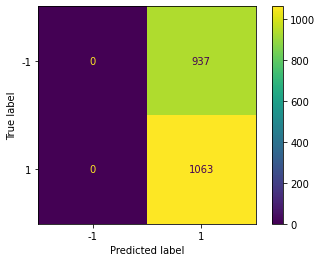

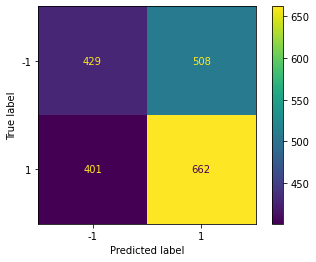

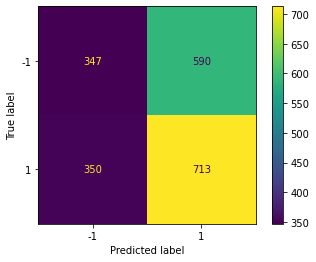

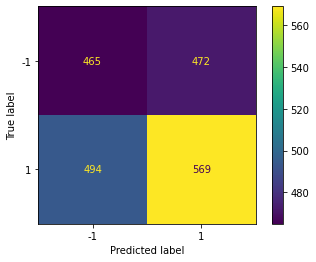

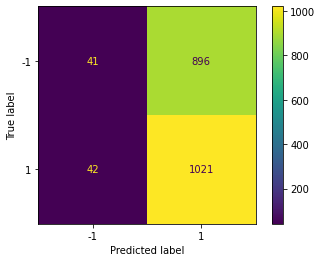

In [31]:
plot_confusion_matrix(grid_dummy, x_val, y_val)
plot_confusion_matrix(grid_linear, x_val, y_val)
plot_confusion_matrix(grid_knn, x_val, y_val)
plot_confusion_matrix(grid_decision_tree, x_val, y_val)
plot_confusion_matrix(grid_random_forest, x_val, y_val)
plt.show()

/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Functio

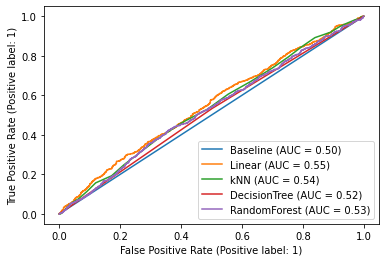

In [32]:
roc_dummy = plot_roc_curve(grid_dummy, x_val, y_val, name = "Baseline")
plot_roc_curve(grid_linear, x_val, y_val, name = "Linear", ax = roc_dummy.ax_)
plot_roc_curve(grid_knn, x_val, y_val, name = "kNN", ax = roc_dummy.ax_)
plot_roc_curve(grid_decision_tree, x_val, y_val, name = "DecisionTree", ax = roc_dummy.ax_)
plot_roc_curve(grid_random_forest, x_val, y_val, name = "RandomForest", ax = roc_dummy.ax_)
plt.show()

# Final model type: linear classification
Since the linear classifier seems to perform the best, we can perform our final test on that one.

In [33]:
new_train_x = pandas.concat([x_train, x_val])
new_train_y = pandas.concat([y_train, y_val])
new_train_x.head()

,1_antimage,2_axe,3_bane,4_bloodseeker,5_crystal_maiden,6_drow_ranger,7_earthshaker,8_juggernaut,9_mirana,11_nevermore,...,radiant_str,radiant_int,radiant_agi,radiant_melee,radiant_ranged,dire_str,dire_int,dire_agi,dire_melee,dire_ranged
9004,0,0,-1,0,0,0,0,0,0,0,...,0.4,0.2,0.4,0.6,0.4,0.4,0.6,0.0,0.6,0.4
6770,0,0,1,0,0,0,0,0,0,0,...,0.0,0.6,0.4,0.2,0.8,0.0,0.4,0.6,0.2,0.8
10162,0,0,1,0,0,0,0,0,0,0,...,0.4,0.4,0.2,0.4,0.6,0.2,0.4,0.4,0.6,0.4
4087,-1,0,0,0,0,0,0,0,0,0,...,0.8,0.2,0.0,0.6,0.4,0.2,0.4,0.4,0.6,0.4
10673,0,0,0,0,-1,0,0,0,0,0,...,0.4,0.4,0.2,0.6,0.4,0.6,0.4,0.0,0.6,0.4


In [34]:
print(new_train_y)

9004    -1
6770    -1
10162    1
4087     1
10673   -1
        ..
10820    1
10474   -1
1241    -1
1282     1
10726    1
Name: match_result, Length: 10386, dtype: int64


In [35]:
linear = SVC(C = 1, kernel = "linear")
linear.fit(new_train_x, new_train_y)

SVC(C=1, kernel='linear')

LINEAR MODEL ACCURACY: 0.5545


/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


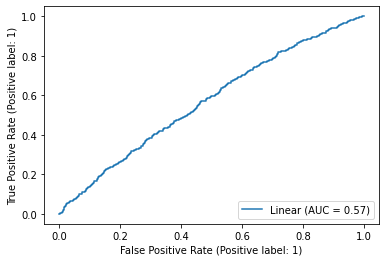

In [36]:
y_true_final, y_pred_final = y_test, grid_linear.predict(x_test)
accuracy_final = accuracy_score(y_true_final, y_pred_final)
print("LINEAR MODEL ACCURACY: " + str(accuracy_final))
plot_roc_curve(linear, x_test, y_test, name = "Linear")
plt.show()

/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


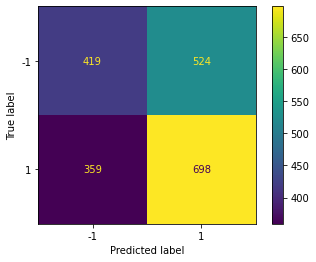

In [37]:
plot_confusion_matrix(linear, x_test, y_test)
plt.show()